In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#open dataset and add paths to array
import pathlib
paths =[]
for path in pathlib.Path("Dataset\mask_weared_incorrect").iterdir():
    #print(path)
    paths.append(path)
for path in pathlib.Path("Dataset\with_mask").iterdir():
    #print(path)
    paths.append(path)
for path in pathlib.Path("Dataset\without_mask").iterdir():
    #print(path)
    paths.append(path)

#check length of paths array to see if all data was copied(8982 files)    
print(len(paths))

8982


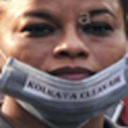

In [3]:
#incorrect_mask = list(paths.glob('mask_weared_incorrect/*'))
PIL.Image.open(paths[0])

In [4]:
#define parameters for the loader
batch_size = 32
img_height = 128
img_width = 128
directory = "Dataset/"

In [5]:
#create training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  seed=9,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8982 files belonging to 3 classes.
Using 7186 files for training.


In [6]:
#create test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=6,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8982 files belonging to 3 classes.
Using 1796 files for validation.


In [7]:
#print the class name
class_names = train_dataset.class_names
print(class_names)

['mask_weared_incorrect', 'with_mask', 'without_mask']


In [8]:
#configure for better preformance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
#Standardize the images ideal to neural network
rescale_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [10]:
#create the model
number_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(number_classes)
])

In [11]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
early_stop = EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=10)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0

In [14]:
#train the model
epochs=100
history = model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/100
225/225 [==============================] - 52s 219ms/step - loss: 0.4366 - accuracy: 0.8171 - val_loss: 0.1840 - val_accuracy: 0.9321
Epoch 2/100
225/225 [==============================] - 49s 218ms/step - loss: 0.1661 - accuracy: 0.9388 - val_loss: 0.1144 - val_accuracy: 0.9644
Epoch 3/100
225/225 [==============================] - 49s 216ms/step - loss: 0.1050 - accuracy: 0.9609 - val_loss: 0.0972 - val_accuracy: 0.9671
Epoch 4/100
225/225 [==============================] - 52s 230ms/step - loss: 0.0691 - accuracy: 0.9756 - val_loss: 0.0574 - val_accuracy: 0.9822
Epoch 5/100
225/225 [==============================] - 51s 228ms/step - loss: 0.0464 - accuracy: 0.9862 - val_loss: 0.0399 - val_accuracy: 0.9883
Epoch 6/100
225/225 [==============================] - 52s 230ms/step - loss: 0.0385 - accuracy: 0.9878 - val_loss: 0.0306 - val_accuracy: 0.9911
Epoch 7/100
225/225 [==============================] - 52s 233ms/step - loss: 0.0256 - accuracy: 0.9921 - val_loss: 0.0294 -

In [18]:
model_df = pd.DataFrame(model.history.history)
model_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.436600,0.817144,0.184037,0.932071
1,0.166074,0.938770,0.114416,0.964365
2,0.104982,0.960896,0.097235,0.967149
3,0.069128,0.975647,0.057427,0.982183
4,0.046395,0.986223,0.039862,0.988307


<AxesSubplot:>

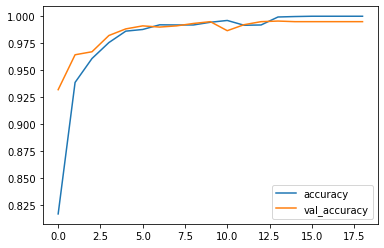

In [19]:
model_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

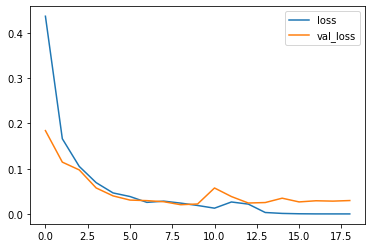

In [20]:
model_df[['loss','val_loss']].plot()

In [22]:
from IPython.display import display
from PIL import Image 
%matplotlib inline

In [ ]:
import faces_from_url_2

['1.png', '10.png', '11.png', '12.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', 'try.png']


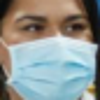

1.png most likely belongs to with_mask with a 100.00 percent confidence.


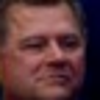

10.png most likely belongs to with_mask with a 65.23 percent confidence.


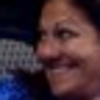

11.png most likely belongs to with_mask with a 99.99 percent confidence.


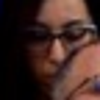

12.png most likely belongs to with_mask with a 79.80 percent confidence.


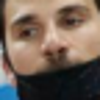

2.png most likely belongs to without_mask with a 99.29 percent confidence.


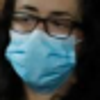

3.png most likely belongs to with_mask with a 100.00 percent confidence.


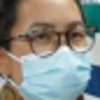

4.png most likely belongs to with_mask with a 100.00 percent confidence.


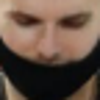

5.png most likely belongs to with_mask with a 99.59 percent confidence.


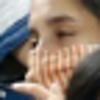

6.png most likely belongs to without_mask with a 99.99 percent confidence.


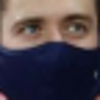

7.png most likely belongs to with_mask with a 100.00 percent confidence.


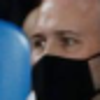

8.png most likely belongs to with_mask with a 100.00 percent confidence.


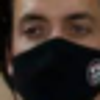

9.png most likely belongs to with_mask with a 100.00 percent confidence.


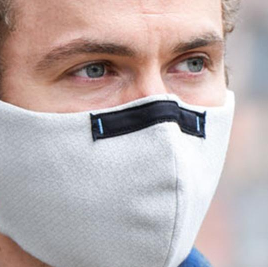

try.png most likely belongs to with_mask with a 100.00 percent confidence.


In [24]:
for folder,subfolder,items in os.walk('web_faces_to_test/'):
    
#     print(folder)
#     print(subfolder)
    print(items)
    
    for pic in items:
        
        test_image = folder+pic
        display_image = PIL.Image.open(test_image)
        width, height = display_image.size
        if (width < 100) or (height < 100):
            display_image = display_image.resize((100,100))
        else:
            pass
            
        display(display_image)
        
        img = keras.preprocessing.image.load_img(
        test_image, target_size=(img_height, img_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        print(
            pic+" most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )